In [97]:
import os
import json
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle

import warnings
warnings.filterwarnings('ignore')

import lgdo.lh5_store as lh5
import lgdo

from multihist import Hist1d, Histdd
from datetime import datetime, timezone
from legendmeta import LegendMetadata

import pulser_analysis as pa

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
"""period, run = 'p06', 'r007'
test_file = f'l200-{period}/{run}/l200-{period}-{run}-pulser-dict.txt'
test_dict_file = f'l200-{period}/{run}/l200-{period}-{run}-pulser-dict.json'
with open(test_file,'r') as datafile:
    n_test = int(len(datafile.read().split())/4)
test_dict = {}
for i in range(n_test):
    with open(test_file,'r') as datafile:
        temp = datafile.read().split()[i*4:(i+1)*4]
    cc4, ampl, att, key = temp
    ampl = float(ampl)
    att = int(att)
    key = f'20230726T{key}'
    if cc4 in test_dict:
        test_dict[cc4]['amplitudes'].append(ampl)
        test_dict[cc4]['attenuations'].append(att)
        test_dict[cc4]['keys'].append(key)
    else:
        test_dict[cc4] = {}
        test_dict[cc4]['amplitudes'] = [ampl]
        test_dict[cc4]['attenuations'] = [att]
        test_dict[cc4]['keys'] = [key]
with open(test_dict_file,'w') as f:
    json.dump(test_dict, f, indent=4)"""

"period, run = 'p06', 'r007'\ntest_file = f'l200-{period}/{run}/l200-{period}-{run}-pulser-dict.txt'\ntest_dict_file = f'l200-{period}/{run}/l200-{period}-{run}-pulser-dict.json'\nwith open(test_file,'r') as datafile:\n    n_test = int(len(datafile.read().split())/4)\ntest_dict = {}\nfor i in range(n_test):\n    with open(test_file,'r') as datafile:\n        temp = datafile.read().split()[i*4:(i+1)*4]\n    cc4, ampl, att, key = temp\n    ampl = float(ampl)\n    att = int(att)\n    key = f'20230726T{key}'\n    if cc4 in test_dict:\n        test_dict[cc4]['amplitudes'].append(ampl)\n        test_dict[cc4]['attenuations'].append(att)\n        test_dict[cc4]['keys'].append(key)\n    else:\n        test_dict[cc4] = {}\n        test_dict[cc4]['amplitudes'] = [ampl]\n        test_dict[cc4]['attenuations'] = [att]\n        test_dict[cc4]['keys'] = [key]\nwith open(test_dict_file,'w') as f:\n    json.dump(test_dict, f, indent=4)"

In [4]:
period, run = 'p06', 'r007'
version = 'tmp/auto'
# meta_path = f'/lfs/l1/legend/data/public/prodenv/prod-blind/{version}/inputs'
# lmeta = LegendMetadata(path=meta_path)
# chmap = lmeta.hardware.configuration.channelmaps.on("20230311T235840Z")

chmap_file = './l200-p03-r%-T%-all-config.json'
with open(chmap_file,'r') as file:
    chmap = json.load(file)


ge_all = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds']
ge_off = ['V07298B', 'P00665A', 'V01386A', 'V01403A', 'V01404A', 'B00091D', 'P00537A',
          'B00091B', 'P00538B', 'P00661A', 'P00665B', 'P00698B']
ge_keys = [ch for ch in ge_all if ch not in ge_off]
ge_rawid = [chmap[ch]['daq']['rawid']  for ch in ge_keys]
ge_table = [f'ch{rawid}' for rawid in ge_rawid]

# raw_dir = f'/lfs/l1/legend/users/dandrea/test_data/raw/tst/{period}-{run}'
raw_dir = '/Volumes/Pennetta_ex/p06-r007'


key_list = open(f'l200-{period}/{run}/l200-{period}-{run}-tst-key.list', "r")
key_list = key_list.read().split('\n')
raw_list = [f'{raw_dir}/l200-{period}-{run}-tst-{key}-tier_raw.lh5' for key in key_list]

test_dict_file = f'l200-{period}/{run}/l200-{period}-{run}-pulser-dict.json'

with open(test_dict_file,'r') as file:
    test_dict = json.load(file)

In [5]:
raw_list[1]

'/Volumes/Pennetta_ex/p06-r007/l200-p06-r007-tst-20230726T102245Z-tier_raw.lh5'

ch1104000 n. pulser events 5352 size 8192


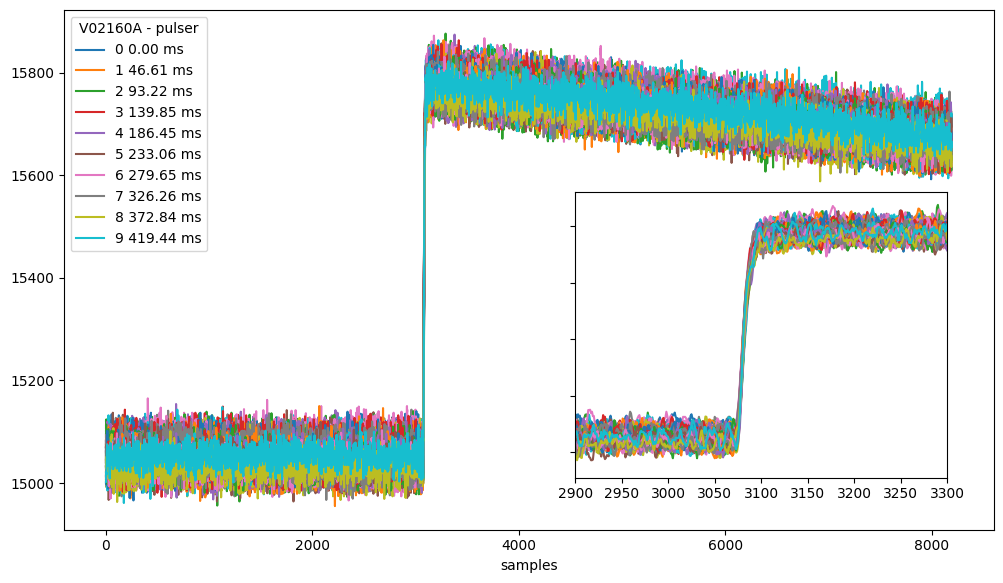

In [57]:
pa.plot_pulser_waveforms(ge_keys[0], 'pulser', raw_list[0], nwf=100, xlim=(2900,3300))

In [18]:
ge_keys[0]

'V02160A'

In [102]:
lgdo.show(lh5_file)

/
└── dsp · table{baseline,timestamp,tp_min,tp_max,wf_min,wf_max,t_sat_lo,t_sat_hi,t_discharge,tp_min_win,tp_max_win,wf_min_win,wf_max_win,bl_mean,bl_std,bl_slope,bl_intercept,bl_slope_diff,bl_slope_rms,pz_slope,pz_std,pz_mean,pz_slope_diff,pz_slope_rms,trapTmax,trapSmax,trapEmax,trapEftp,cuspEmax,zacEmax,zacEftp,cuspEftp,tp_0_est,tp_0_atrap,tp_01,tp_10,tp_20,tp_50,tp_80,tp_90,tp_95,tp_99,tp_100,A_max,tp_aoe_max,QDrift,dt_eff,tp_80_lq,lq80,A_max_tri,A_min,aoe_t_min,A_min_upslope200,A_max_upslope200,A_min_slope200,A_max_slope200,tp_curr_min,tp_curr_max,curr_min,curr_max,dt_eff_invert,trapTmax_invert,trapTftp_invert,tp_0_invert,tp_100_invert,tp_99_invert,tp_90_invert,tp_80_invert,tp_50_invert,tp_20_invert,tp_10_invert} 
    ├── A_max · array<1>{real} 
    ├── A_max_slope200 · array<1>{real} 
    ├── A_max_tri · array<1>{real} 
    ├── A_max_upslope200 · array<1>{real} 
    ├── A_min · array<1>{real} 
    ├── A_min_slope200 · array<1>{real} 
    ├── A_min_upslope200 · array<1>{real} 
    

In [135]:
len(store.read_object("dsp/A_max", lh5_file)[0]), store.read_object("dsp/A_max", lh5_file)[1]


(5351, 5351)

In [136]:
(store.read_object("dsp", lh5_file)[0]), store.read_object("dsp/A_max", lh5_file)[1]


(Table(dict={'baseline': Array([15055 15019 ... 15040 15002], attrs={'datatype': 'array<1>{real}'}), 'timestamp': Array([1.69036697e+09 1.69036697e+09 ... 1.69036722e+09 1.69036722e+09], attrs={'datatype': 'array<1>{real}', 'units': 's'}), 'tp_min': Array([27648. 8256. ... 26496. 27648.], attrs={'datatype': 'array<1>{real}', 'units': 'ns'}), 'tp_max': Array([50688. 51456. ... 50592. 50976.], attrs={'datatype': 'array<1>{real}', 'units': 'ns'}), 'wf_min': Array([15004.5 14968.333 ... 14987.833 14935.501], attrs={'datatype': 'array<1>{real}', 'units': 'ADC'}), 'wf_max': Array([18686.834 18632.834 ... 18682.666 18614.668], attrs={'datatype': 'array<1>{real}', 'units': 'ADC'}), 't_sat_lo': Array([0. 0. ... 0. 0.], attrs={'datatype': 'array<1>{real}', 'units': 'ADC'}), 't_sat_hi': Array([0. 0. ... 0. 0.], attrs={'datatype': 'array<1>{real}', 'units': 'ADC'}), 't_discharge': Array([0. 0. ... 0. 0.], attrs={'datatype': 'array<1>{real}', 'units': 'ns'}), 'tp_min_win': Array([48480. 43920. ... 

In [142]:
dsp_dict = store.read_object("dsp", lh5_file)[0]
A_max = store.read_object("dsp/A_max", lh5_file)[0]

In [152]:
sorted(dsp_dict.keys())

['A_max',
 'A_max_slope200',
 'A_max_tri',
 'A_max_upslope200',
 'A_min',
 'A_min_slope200',
 'A_min_upslope200',
 'QDrift',
 'aoe_t_min',
 'baseline',
 'bl_intercept',
 'bl_mean',
 'bl_slope',
 'bl_slope_diff',
 'bl_slope_rms',
 'bl_std',
 'curr_max',
 'curr_min',
 'cuspEftp',
 'cuspEmax',
 'dt_eff',
 'dt_eff_invert',
 'lq80',
 'pz_mean',
 'pz_slope',
 'pz_slope_diff',
 'pz_slope_rms',
 'pz_std',
 't_discharge',
 't_sat_hi',
 't_sat_lo',
 'timestamp',
 'tp_01',
 'tp_0_atrap',
 'tp_0_est',
 'tp_0_invert',
 'tp_10',
 'tp_100',
 'tp_100_invert',
 'tp_10_invert',
 'tp_20',
 'tp_20_invert',
 'tp_50',
 'tp_50_invert',
 'tp_80',
 'tp_80_invert',
 'tp_80_lq',
 'tp_90',
 'tp_90_invert',
 'tp_95',
 'tp_99',
 'tp_99_invert',
 'tp_aoe_max',
 'tp_curr_max',
 'tp_curr_min',
 'tp_max',
 'tp_max_win',
 'tp_min',
 'tp_min_win',
 'trapEftp',
 'trapEmax',
 'trapSmax',
 'trapTftp_invert',
 'trapTmax',
 'trapTmax_invert',
 'wf_max',
 'wf_max_win',
 'wf_min',
 'wf_min_win',
 'zacEftp',
 'zacEmax']

In [161]:
cc4_id = chmap[ge_keys[2]]['electronics']['cc4']['id']

In [163]:
ge_keys

['V02160A',
 'V02160B',
 'V05261B',
 'V05266A',
 'V05266B',
 'V05268B',
 'V05612A',
 'V07647A',
 'V07647B']

In [158]:
test_dict[cc4_id]['keys']

['20230726T101651Z',
 '20230726T102245Z',
 '20230726T102828Z',
 '20230726T103316Z',
 '20230726T104032Z',
 '20230726T104510Z',
 '20230726T104959Z',
 '20230726T105428Z']

In [162]:
test_dict[cc4_id]['keys']

['20230726T101651Z',
 '20230726T102245Z',
 '20230726T102828Z',
 '20230726T103316Z',
 '20230726T104032Z',
 '20230726T104510Z',
 '20230726T104959Z',
 '20230726T105428Z']

In [148]:
len(np.array((dsp_dict['A_max'])) - np.array(A_max))

5351

In [101]:
lh5_file = 'my_objects.lh5'

In [ ]:
test_dict[cc4_id]['keys']

In [22]:
chmap[ge_keys[1]]['daq']['rawid']

1104001

In [32]:
store = lh5.LH5Store()

In [33]:
store

In [37]:
cc4_id = chmap[ge_keys[1]]['electronics']['cc4']['id']

In [38]:
test_dict[cc4_id]['keys']

['20230726T101651Z',
 '20230726T102245Z',
 '20230726T102828Z',
 '20230726T103316Z',
 '20230726T104032Z',
 '20230726T104510Z',
 '20230726T104959Z',
 '20230726T105428Z']

In [39]:
cc4_id

'C3'

In [185]:
out_lh5_cc4 = f'./l200-p06/{run}/dsp/small/l200-{period}-{run}-small_dsp-{cc4_id}.lh5'

lgdo.show(out_lh5_cc4)

/
├── ch1104000 · HDF5 group 
│   ├── amplitudes · array<1>{real} 
│   ├── attenuations · array<1>{real} 
│   ├── puls ene · array<1>{real} 
│   └── uncal ene · array<1>{real} 
├── ch1104001 · HDF5 group 
│   ├── amplitudes · array<1>{real} 
│   ├── attenuations · array<1>{real} 
│   ├── puls ene · array<1>{real} 
│   └── uncal ene · array<1>{real} 
└── ch1104002 · HDF5 group 
    ├── amplitudes · array<1>{real} 
    ├── attenuations · array<1>{real} 
    ├── puls ene · array<1>{real} 
    └── uncal ene · array<1>{real} 


In [183]:
par_dsp_file = './l200-p03-r000-cal-T%-par_dsp-overwrite.json'
with open(par_dsp_file,'r') as file:
    par_dsp = json.load(file)

dsp_proc_chain_file = './l200-p01-r%-T%-ICPC-dsp_proc_chain.json'
with open(dsp_proc_chain_file,'r') as file:
    dsp_proc_chain = json.load(file)

In [49]:
dsp_proc_chain

{'outputs': ['baseline',
  'timestamp',
  'daqenergy',
  't_sat_lo',
  't_sat_hi',
  'tp_min',
  'tp_max',
  'wf_min',
  'wf_max',
  't_discharge',
  'tp_min_win',
  'tp_max_win',
  'wf_min_win',
  'wf_max_win',
  'wf_mean',
  'wf_std',
  'wf_slope',
  'wf_intercept',
  'bl_mean',
  'bl_std',
  'bl_slope',
  'bl_intercept',
  'bl_slope_diff',
  'bl_slope_rms',
  'pz_slope',
  'pz_std',
  'pz_mean',
  'pz_slope_diff',
  'pz_slope_rms',
  'baselineEmax',
  'tailEmax',
  'trapTmax',
  'trapSmax',
  'trapEmax',
  'trapEftp',
  'cuspEmax',
  'zacEmax',
  'zacEftp',
  'cuspEftp',
  'baselineEmax',
  'tailEmax',
  'tp_0_est',
  'tp_0_atrap',
  'tp_01',
  'tp_10',
  'tp_20',
  'tp_50',
  'tp_80',
  'tp_90',
  'tp_95',
  'tp_99',
  'tp_100',
  'A_max',
  'tp_aoe_max',
  'QDrift',
  'dt_eff',
  'tp_80_lq',
  'lq80',
  'A_max_tri',
  'A_min',
  'aoe_t_min',
  'A_min_upslope200',
  'A_max_upslope200',
  'A_min_slope200',
  'A_max_slope200',
  'tp_curr_min',
  'tp_curr_max',
  'curr_min',
  'curr_m

[0.00627972 0.03147314 0.06279716 0.12529681 0.17698645 0.25
 0.31473135 0.35313439]
Pulser processing for V05266A String 1 CC4 C3
20230726T101651Z n. pulser events 5352 size 8192
Time to produce DSP data 13.0 s
20230726T102245Z n. pulser events 5351 size 8192
Time to produce DSP data 12.7 s


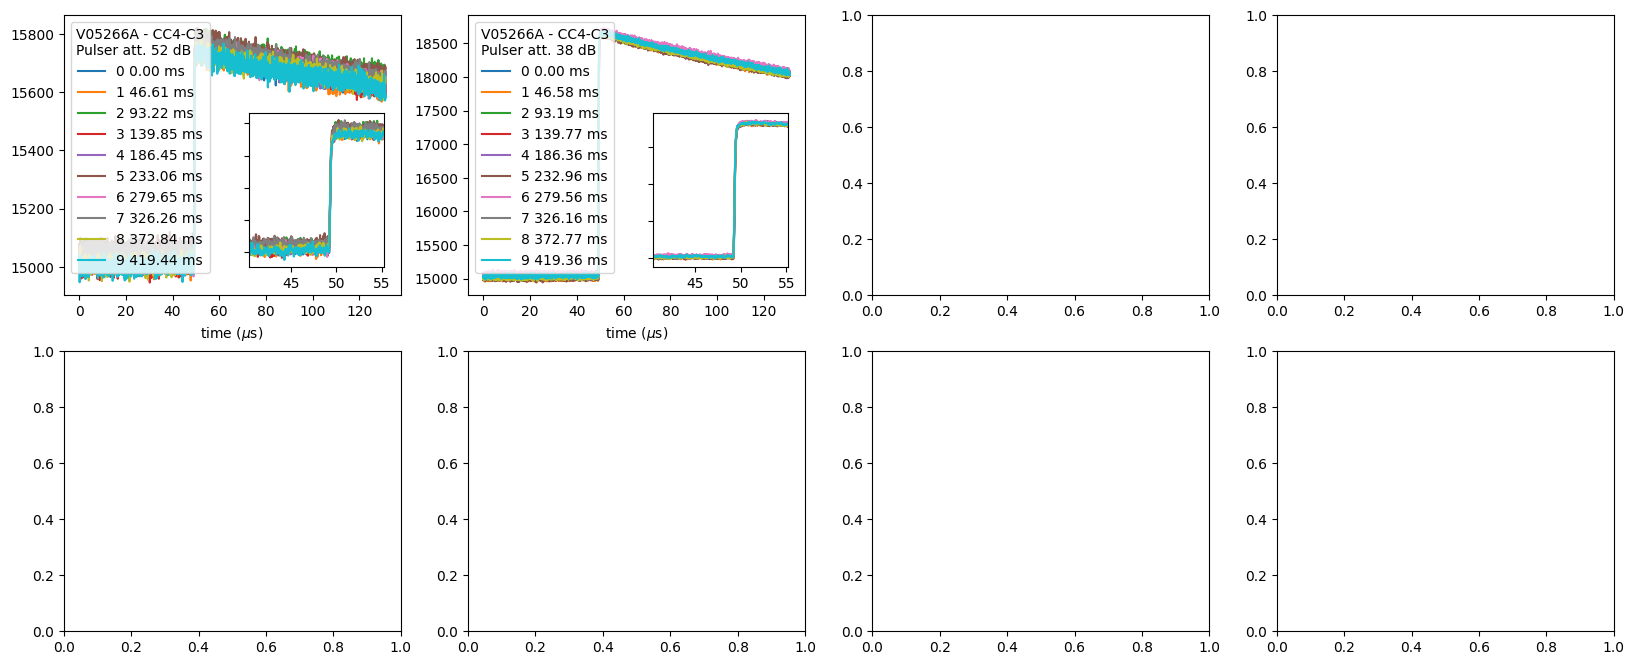

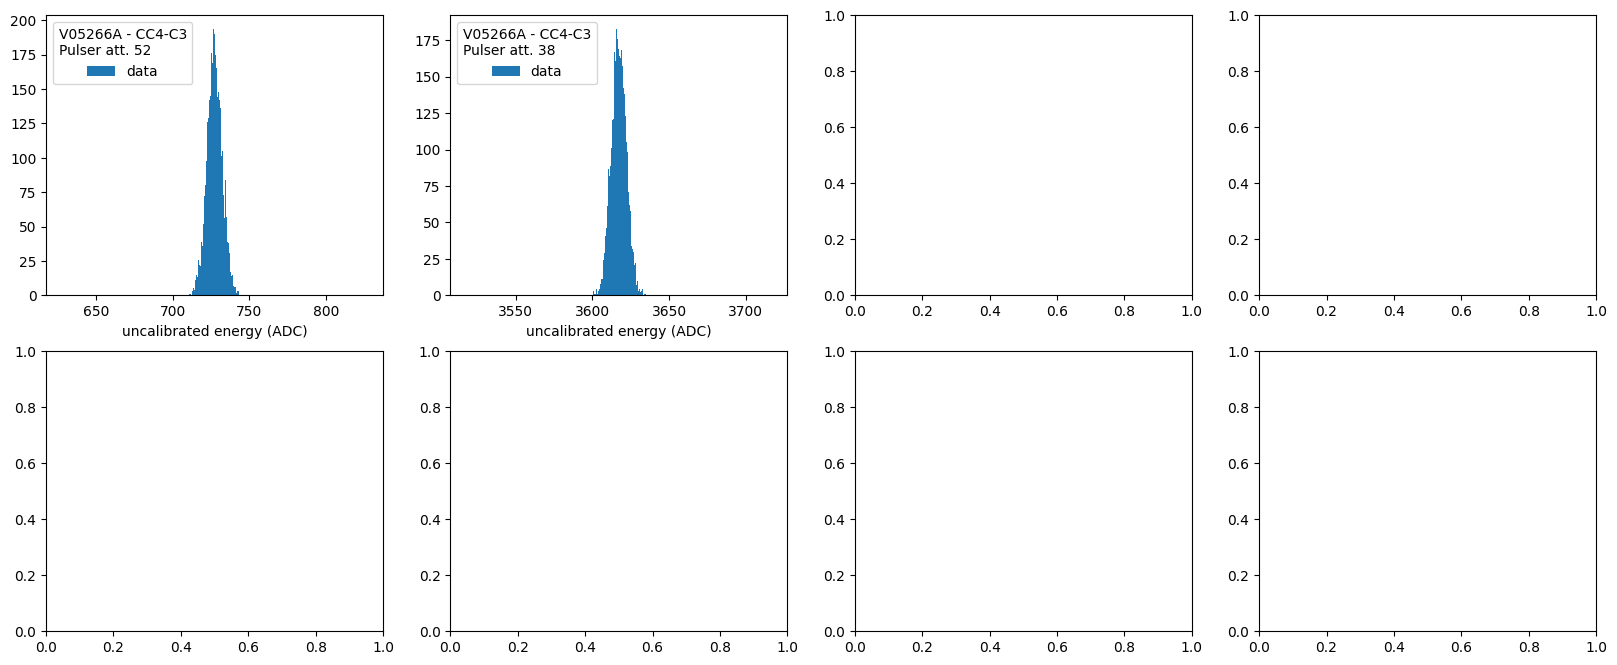

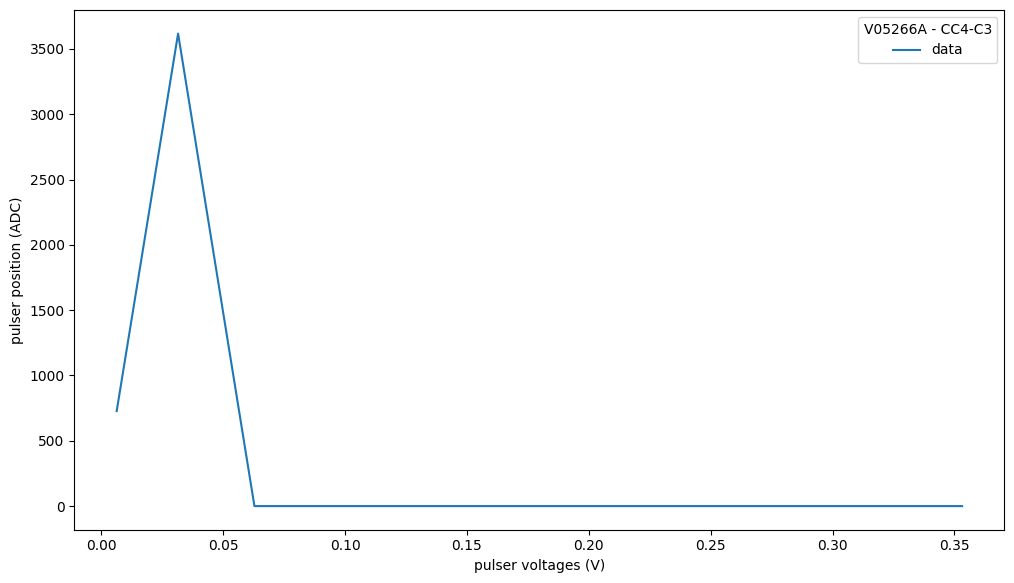

In [116]:
ciccio = pa.pulser_processing('p06','r007',ge_keys[3], test_dict_file, raw_dir)

In [119]:
store.read_object()

In [124]:
lh5_file = f'./l200-p06/{run}/dsp/l200_{run}_pulser_test_acq.lh5'

In [125]:
lgdo.show(lh5_file)

/
└── dsp · table{baseline,timestamp,tp_min,tp_max,wf_min,wf_max,t_sat_lo,t_sat_hi,t_discharge,tp_min_win,tp_max_win,wf_min_win,wf_max_win,bl_mean,bl_std,bl_slope,bl_intercept,bl_slope_diff,bl_slope_rms,pz_slope,pz_std,pz_mean,pz_slope_diff,pz_slope_rms,trapTmax,trapSmax,trapEmax,trapEftp,cuspEmax,zacEmax,zacEftp,cuspEftp,tp_0_est,tp_0_atrap,tp_01,tp_10,tp_20,tp_50,tp_80,tp_90,tp_95,tp_99,tp_100,A_max,tp_aoe_max,QDrift,dt_eff,tp_80_lq,lq80,A_max_tri,A_min,aoe_t_min,A_min_upslope200,A_max_upslope200,A_min_slope200,A_max_slope200,tp_curr_min,tp_curr_max,curr_min,curr_max,dt_eff_invert,trapTmax_invert,trapTftp_invert,tp_0_invert,tp_100_invert,tp_99_invert,tp_90_invert,tp_80_invert,tp_50_invert,tp_20_invert,tp_10_invert} 
    ├── A_max · array<1>{real} 
    ├── A_max_slope200 · array<1>{real} 
    ├── A_max_tri · array<1>{real} 
    ├── A_max_upslope200 · array<1>{real} 
    ├── A_min · array<1>{real} 
    ├── A_min_slope200 · array<1>{real} 
    ├── A_min_upslope200 · array<1>{real} 
    

In [126]:
lh5_file[]

TypeError: string indices must be integers

In [ ]:
                    l200-p06-r007_pulser-test_acq1.lh5
./l200-p06/r007/dsp/l200-p06-r007_pulser_test_acq1.lh5

In [114]:
# lh5_file = f'./l200-p06/{run}/dsp/l200-p06-{run}_pulser_test_acq1.lh5'

lh5_file = '/Users/francescoborra/software/legend_200/legend-pulser/l200-p06/r007/dsp/l200-p06-r007_pulser_test_acq1.lh5'

store = lh5.LH5Store()
store.gimme_file(lh5_file, "r")

FileNotFoundError: could not find path matching /Users/francescoborra/software/legend_200/legend-pulser/l200-p06/r007/dsp/l200-p06-r007_pulser_test_acq1.lh5

In [79]:
ene, n_rows = store.read_object(f'V05261B/pulser_energy', lh5_file)

FileNotFoundError: could not find path matching ./r007/dsp/l200_r007_pulser_test_acq1.lh5

In [87]:
!ls ./


__pycache__
l200-p01-r%-T%-ICPC-dsp_proc_chain.json
l200-p02
l200-p02-r016_pulser_test.ipynb
l200-p02-r017_pulser_test.ipynb
l200-p02-r020_pulser_test.ipynb
l200-p03
l200-p03-r%-T%-all-config.json
l200-p03-r000-cal-T%-par_dsp-overwrite.json
l200-p03-r000_pulser_stability.ipynb
l200-p03-r005_pulser_stability_tests.ipynb
l200-p06
l200-p06-r007_pulser_test.ipynb
l200-p06_pulser_stability.ipynb
pulser_analysis.py


In [109]:
caio = store.gimme_file(lh5_file, "r")

In [113]:
caio['dsp']()

TypeError: 'Group' object is not callable

In [76]:
ge_keys = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]

In [77]:
ge_keys

['V02160A',
 'V02160B',
 'V05261B',
 'V05266A',
 'V05266B',
 'V05268B',
 'V05612A',
 'V07647A',
 'V07647B']

In [64]:
ciccio['wf_max']

Array([15779.499 15770.5   15802.334 ... 15781.667 15742.001 15794.667], attrs={'datatype': 'array<1>{real}', 'units': 'ADC'})

1.5443114430046123

In [11]:
i = 1

In [58]:
test_dict_file

'l200-p06/r007/l200-p06-r007-pulser-dict.json'

In [24]:
string = 1

In [25]:
ge_keys = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]

In [26]:
ge_keys

['V02160A',
 'V02160B',
 'V05261B',
 'V05266A',
 'V05266B',
 'V05268B',
 'V05612A',
 'V07647A',
 'V07647B']

In [48]:
ge_numbers_1 = [f"{chmap[ch]['daq']['rawid']:03}"[-3:] for ch in ge_keys]

In [31]:
ge_numbers

[{'crate': 0,
  'card': {'id': 1, 'address': '0x410', 'serialno': None},
  'channel': 0,
  'rawid': 1104000},
 {'crate': 0,
  'card': {'id': 1, 'address': '0x410', 'serialno': None},
  'channel': 1,
  'rawid': 1104001},
 {'crate': 0,
  'card': {'id': 1, 'address': '0x410', 'serialno': None},
  'channel': 2,
  'rawid': 1104002},
 {'crate': 0,
  'card': {'id': 1, 'address': '0x410', 'serialno': None},
  'channel': 3,
  'rawid': 1104003},
 {'crate': 0,
  'card': {'id': 1, 'address': '0x410', 'serialno': None},
  'channel': 4,
  'rawid': 1104004},
 {'crate': 0,
  'card': {'id': 1, 'address': '0x420', 'serialno': None},
  'channel': 5,
  'rawid': 1104005},
 {'crate': 0,
  'card': {'id': 2, 'address': '0x410', 'serialno': None},
  'channel': 0,
  'rawid': 1105600},
 {'crate': 0,
  'card': {'id': 2, 'address': '0x420', 'serialno': None},
  'channel': 2,
  'rawid': 1105602},
 {'crate': 0,
  'card': {'id': 2, 'address': '0x420', 'serialno': None},
  'channel': 3,
  'rawid': 1105603}]

In [49]:
ge_numbers_1

['000', '001', '002', '003', '004', '005', '600', '602', '603']

string 1


KeyError: "'ch1104000/pulser_energy' not in ./l200-p06/r007/dsp/l200_r007_pulser_test_acq.lh5"

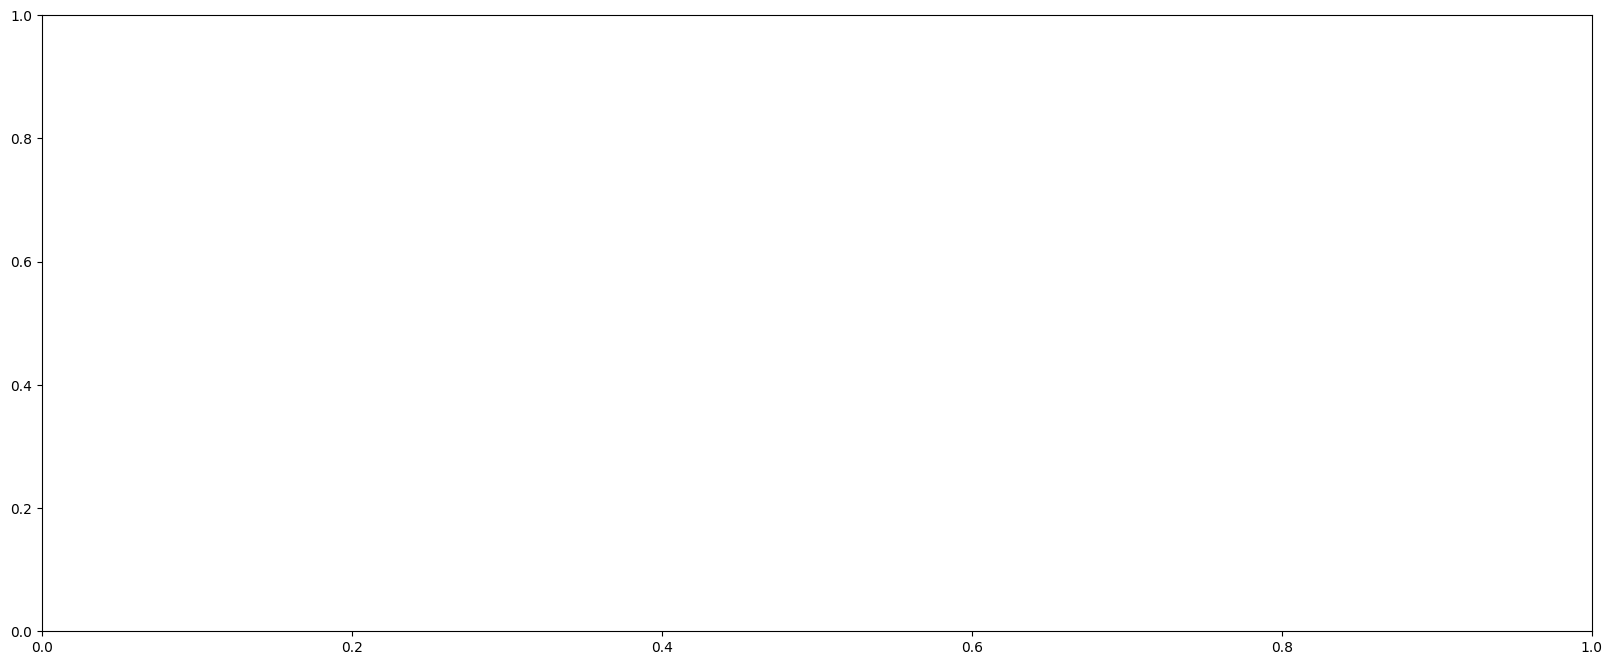

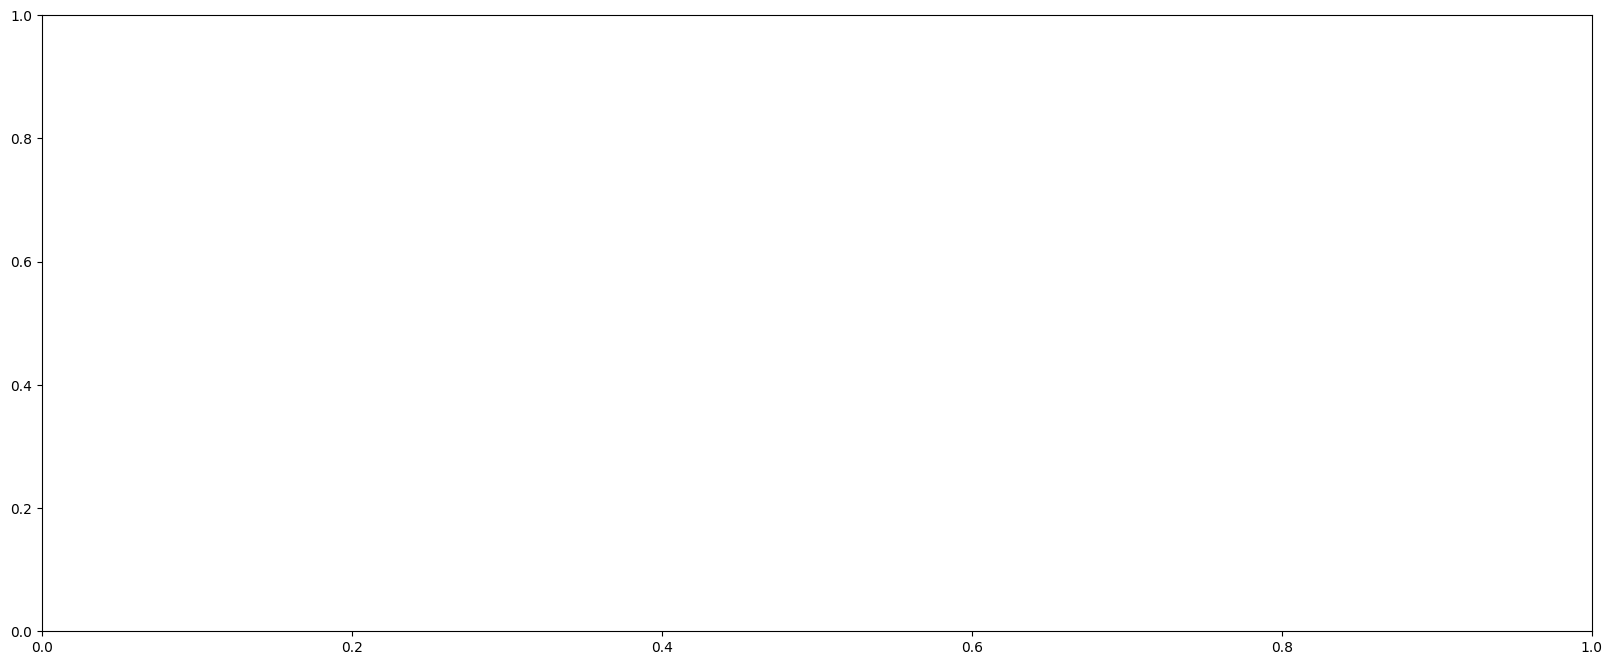

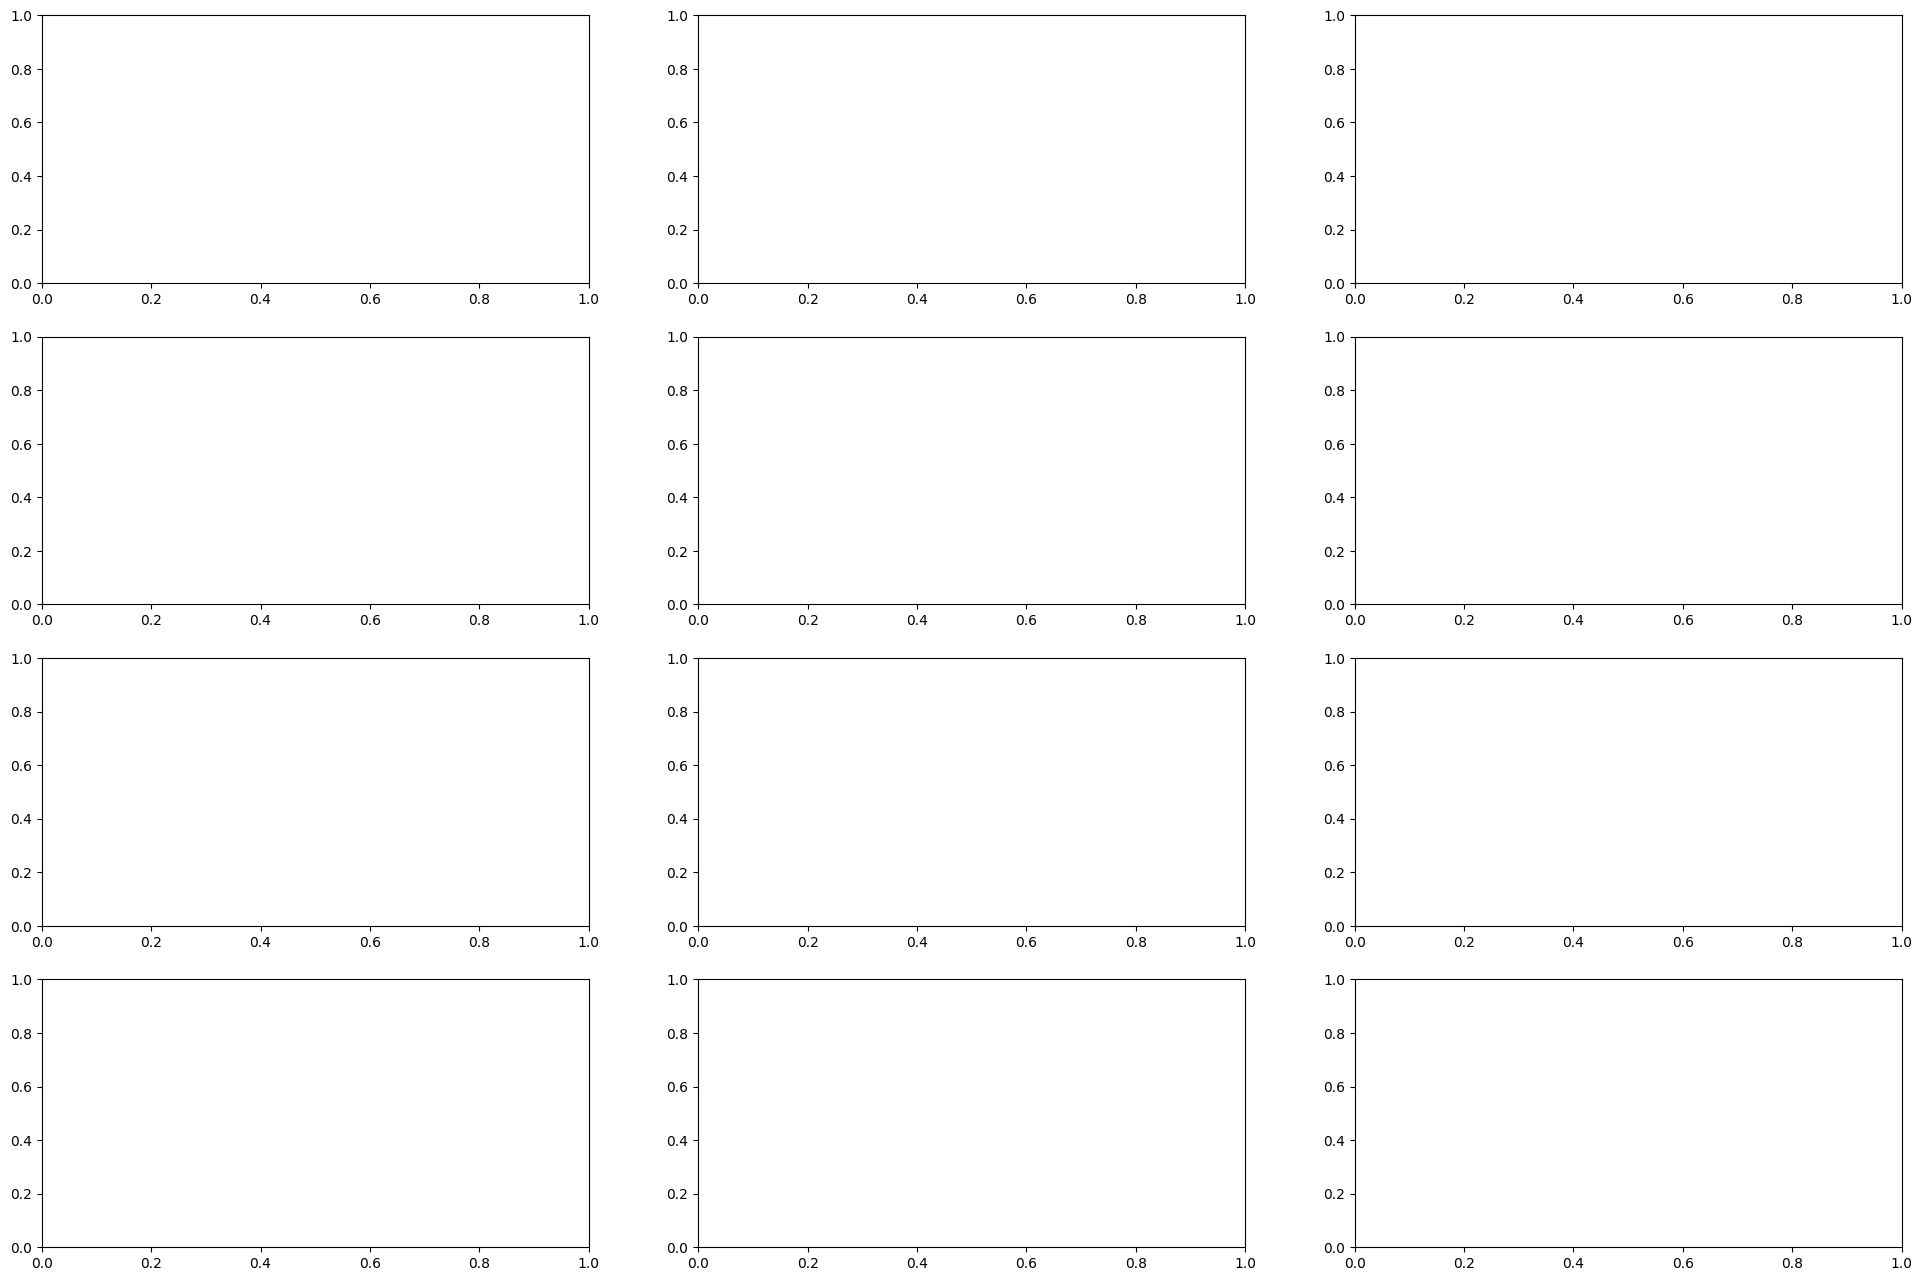

In [118]:
pa.pulser_dsp_analysis(run, chmap, test_dict_file, n_test=2,n_acq=i, nstring=None,
                       plot_dir='r007/pulser_test/plots')

In [ ]:
def plot_pulser_info(chmap, test_dict, n_test, nstring = None, plot_dir = None):
    with open(test_dict_file,'r') as file:
        test_dict = json.load(file)
    acquistions = [k for k in test_dict[f'test{n_test}'].keys()][:]
    print(acquistions)
    fig0, axis0 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    fig1, axis1 = plt.subplots(nrows=4, ncols=3,figsize=(24,16), facecolor='white')
    ge_off = (26,33,46,47,48,50,84,85,94,105,112,116,117,120,122)
    strings = np.array([int(chmap[ch]['location']['string']) for ch in chmap.keys() if chmap[ch]['system']=='geds'])
    if nstring is None: nstring = strings.max()
    for string in range(1,nstring+1):
        ax0 = axis0.flat[string-1]
        ax1 = axis1.flat[string-1]
        #if n_test == 2: axin = ax1.inset_axes([0.24, 0.53, 0.35, 0.45])
        det_names = [ch for ch in chmap.keys() if chmap[ch]['system']=='geds' and chmap[ch]['location']['string']==string]
        ge_numbers = [chmap[ch]['daq']['fcid'] for ch in det_names]
        cc4s = [chmap[ch]['electronics']['cc4']['id'] for ch in det_names]
        chns = [f'ch{n:03}' for n in ge_numbers if n not in ge_off ]
        det_names = [ch for n, ch in zip(ge_numbers,det_names) if n not in ge_off ]
        rate = [float(test_dict[f'test{n_test}'][f'{n_acq}']['rate']) for n_acq in acquistions]
        energy = [float(test_dict[f'test{n_test}'][f'{n_acq}']['energy'])*1000 for n_acq in acquistions]
        for i, chn in enumerate(chns[:]):
            if det_names[i] == 'B00089D': continue
            #try:
            fwhm = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['fwhm'] for n_acq in acquistions]
            fwhm_err = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['fwhm_err'] for n_acq in acquistions]
            pos = [test_dict[f'test{n_test}'][f'{n_acq}'][chn]['position'] for n_acq in acquistions]
            if n_test == 1:
                ax0.errorbar(rate, fwhm,yerr=fwhm_err,marker='o', label=f'{det_names[i]}-{cc4s[i]}')
                ax1.plot(rate, pos,'o-',label=f'{det_names[i]}-{cc4s[i]}')
            if n_test == 2:
                ax0.errorbar(energy, fwhm,yerr=fwhm_err,marker='o', label=f'{det_names[i]}-{cc4s[i]}')
                ax1.plot(energy, pos,'o-',label=f'{det_names[i]}-{cc4s[i]}')
                #axin.plot(energy, pos,'o-',label=f'{det_names[i]}')
            #except: pass
        ax0.legend(title=f'String {string}',loc='upper left')
        if n_test == 1:
            ax0.set_xscale('log')
            ax1.set_xscale('log')
            x_name = 'rate (Hz)'
            fstring = 'rate'
            xlims = (0.005,120)
        if n_test == 2:
            x_name = 'expected position (keV)'
            fstring = 'position'
            xlims = (-2000,6100)
        ax0.set_xlabel(x_name)
        ax0.set_ylabel('FWHM (keV)')
        ax0.set_xlim(xlims[0],xlims[1])
        ax1.legend(title=f'String {string}',loc='upper left')
        ax1.set_xlabel(x_name)
        ax1.set_ylabel('pulser position (keV)')
        ax1.set_xlim(xlims[0],xlims[1])
        """if n_test == 2:
            axin.set_xlim(40,250)
            axin.set_ylim(40,500)
            axin.set_yticklabels('')"""
    if plot_dir is not None:
        fig0.savefig(f'{plot_dir}/test{n_test}_fwhm_vs_{fstring}.png',dpi=300, bbox_inches='tight')
        fig1.savefig(f'{plot_dir}/test{n_test}_position_vs_{fstring}.png',dpi=300, bbox_inches='tight')

In [ ]:
plot_pulser_info(chmap, test_dict, n_test=1, nstring = None, plot_dir = 'r017/pulser_test/plots')

In [ ]:
plot_pulser_info(chmap, test_dict, n_test=2, nstring = None, plot_dir = 'r017/pulser_test/plots')